<a href="https://colab.research.google.com/github/TiagoBruno00/Redes_Neuronales/blob/main/1_Autoencoder_consigna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# Comprobación de disponibilidad de GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


In [ ]:
# 1. Descargar y preparar los datos
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),])

train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
valid_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: data/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw

Using downloaded and verified file: data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3865311.68it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7145028.79it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
# 2. Definición del autoencoder
class Autoencoder(nn.Module):
    def __init__(self, hidden_size=128, dropout_rate=0):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),  # Conv1
            nn.ReLU(),                         # ReLU1
            nn.Dropout(dropout_rate),         # Dropout1
            nn.MaxPool2d(kernel_size=2),      # MaxPool1
            nn.Conv2d(16, 32, kernel_size=3), # Conv2
            nn.ReLU(),                         # ReLU2
            nn.Dropout(dropout_rate),         # Dropout2
            nn.MaxPool2d(kernel_size=2),      # MaxPool2
            nn.Flatten(),                      # Flatten
            nn.Linear(32 * 5 * 5, hidden_size), # Linear1
            nn.ReLU(),                         # ReLU3
            nn.Dropout(dropout_rate)           # Dropout3
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 32 * 5 * 5), # Linear2
            nn.ReLU(),                         # ReLU4
            nn.Dropout(dropout_rate),         # Dropout4
            nn.Unflatten(1, (32, 5, 5)),       # Unflatten
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, output_padding=1), # ConvTranspose2d1
            nn.ReLU(),                         # ReLU5
            nn.Dropout(dropout_rate),         # Dropout5
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, output_padding=1),  # ConvTranspose2d2
            nn.Sigmoid(),                     # Sigmoid
            nn.Dropout(dropout_rate)          # Dropout6
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# 3. Inicialización
autoencoder = Autoencoder(hidden_size=128, dropout_rate=0)
autoencoder.to(device)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [ ]:
# 4. Entrenamiento y Validación
def train(loader, model, optimizer, criterion):
    model.train()
    train_loss = 0.0
    for data in loader:
        inputs, _ = data
        inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(inputs.size(0), 1, 28, 28).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def validate(loader, model, criterion):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
            outputs = model(inputs)
            loss = criterion(outputs, inputs.view(inputs.size(0), 1, 28, 28).float())
            valid_loss += loss.item()
    return valid_loss / len(loader)

# Uso de las funciones de entrenamiento y validación
num_epochs = 20
train_losses_incorrecto = []  # Error de entrenamiento sin modo evaluación
train_losses = []  # Error de entrenamiento con modo evaluación
test_losses = []

for epoch in range(num_epochs):
    train_loss_incorrecto = train(train_loader, autoencoder, optimizer, criterion)
    train_loss = validate(train_loader, autoencoder, criterion)  # Error de entrenamiento con modo evaluación
    test_loss = validate(valid_loader, autoencoder, criterion)
    train_losses_incorrecto.append(train_loss_incorrecto)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Imprimir progreso
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {test_loss:.4f}')

Epoch [1/20], Train Loss: 0.0305, Valid Loss: 0.0306
Epoch [2/20], Train Loss: 0.0245, Valid Loss: 0.0246
Epoch [3/20], Train Loss: 0.0225, Valid Loss: 0.0227
Epoch [4/20], Train Loss: 0.0219, Valid Loss: 0.0220
Epoch [5/20], Train Loss: 0.0214, Valid Loss: 0.0216
Epoch [6/20], Train Loss: 0.0211, Valid Loss: 0.0212
Epoch [7/20], Train Loss: 0.0209, Valid Loss: 0.0211
Epoch [8/20], Train Loss: 0.0206, Valid Loss: 0.0208
Epoch [9/20], Train Loss: 0.0205, Valid Loss: 0.0207
Epoch [10/20], Train Loss: 0.0204, Valid Loss: 0.0206
Epoch [11/20], Train Loss: 0.0203, Valid Loss: 0.0205
Epoch [12/20], Train Loss: 0.0201, Valid Loss: 0.0203
Epoch [13/20], Train Loss: 0.0202, Valid Loss: 0.0204
Epoch [14/20], Train Loss: 0.0200, Valid Loss: 0.0202
Epoch [15/20], Train Loss: 0.0200, Valid Loss: 0.0202
Epoch [16/20], Train Loss: 0.0199, Valid Loss: 0.0202
Epoch [17/20], Train Loss: 0.0199, Valid Loss: 0.0201
Epoch [18/20], Train Loss: 0.0198, Valid Loss: 0.0200
Epoch [19/20], Train Loss: 0.0198, Va

In [ ]:
# Guardar pesos del autoencoder
torch.save(autoencoder.state_dict(), 'pesos_autoencoder_consigna.pth')
torch.save(train_losses, 'mse_train_64_consigna.pth')
torch.save(test_losses, 'mse_test_64_consigna.pth')

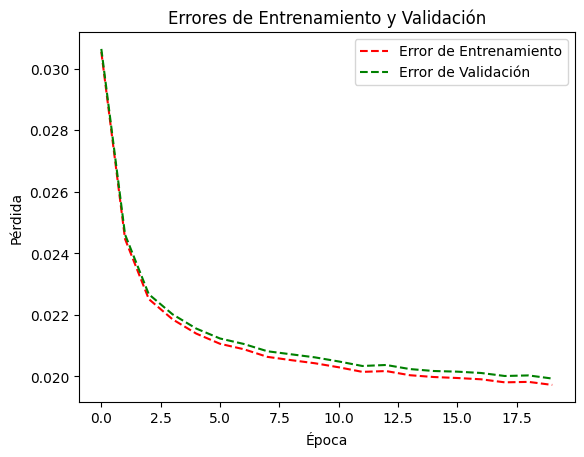

In [ ]:
# 5. Gráfico de errores de entrenamiento y validación
plt.plot(train_losses, label='Error de Entrenamiento', color='red', linestyle='--')
plt.plot(test_losses, label='Error de Validación', color='green', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Errores de Entrenamiento y Validación')
plt.legend()
plt.show()

In [ ]:
# 6. Decisión sobre el número de épocas

def determinar_numero_epocas_error(error_set, patience=10, min_delta=0.001):
    best_error = error_set[0]
    epochs_without_improvement = 0
    for i, error in enumerate(error_set):
        if error < best_error - min_delta:
            best_error = error
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                return i - patience
    return len(error_set)  # Si no converge en el conjunto, se devuelve el número total de épocas

z, w, y = [determinar_numero_epocas_error(train_losses_incorrecto), determinar_numero_epocas_error(test_losses), determinar_numero_epocas_error(train_losses)]
print(f"Época según error durante el entrenamiento: {z}")
print(f"Época según error de validación: {w}")
print(f"Época según error de entrenamiento: {y}")


Época según error durante el entrenamiento: 20
Época según error de validación: 20
Época según error de entrenamiento: 20


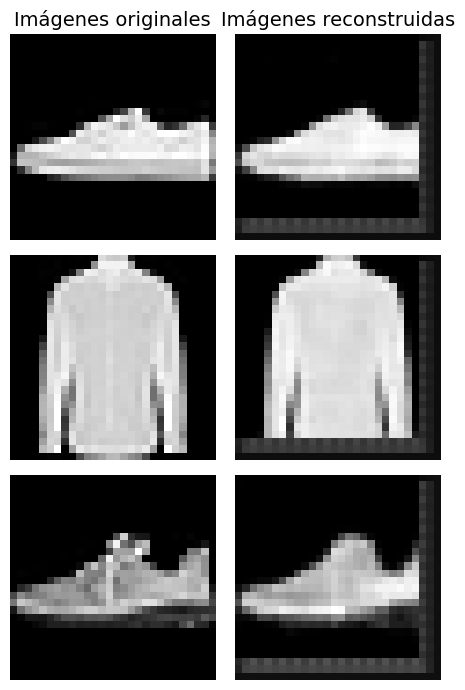

In [ ]:
# 7. Imágenes origninales vs predichas

# Crear semilla para obtener un índice aleatorio y reproducible
seed = 6
torch.manual_seed(seed)
random.seed(seed)

# Obtener la lista de índices del conjunto de validación
indices_val = list(range(len(valid_dataset)))

# Seleccionar tres índices de muestra aleatorios y fijarlos
sample_idx1, sample_idx2, sample_idx3 = random.sample(indices_val, 3)

# Obtener las nuevas imágenes y sus etiquetas del conjunto de validación
imagen1, label1 = valid_dataset[sample_idx1]
imagen2, label2 = valid_dataset[sample_idx2]
imagen3, label3 = valid_dataset[sample_idx3]

# Obtener las predicciones del modelo
with torch.no_grad():
    # Imagen 1
    imagen1_gpu = imagen1.to(device)
    imagen1_flatten = imagen1_gpu.unsqueeze(0).to(device)
    pred1_gpu = autoencoder(imagen1_flatten)
    pred1_cpu = pred1_gpu.cpu().view(1, 28, 28).squeeze().numpy()

    # Imagen 2
    imagen2_gpu = imagen2.to(device)
    imagen2_flatten = imagen2_gpu.unsqueeze(0).to(device)
    pred2_gpu = autoencoder(imagen2_flatten)
    pred2_cpu = pred2_gpu.cpu().view(1, 28, 28).squeeze().numpy()

    # Imagen 3
    imagen3_gpu = imagen3.to(device)
    imagen3_flatten = imagen3_gpu.unsqueeze(0).to(device)
    pred3_gpu = autoencoder(imagen3_flatten)
    pred3_cpu = pred3_gpu.cpu().view(1, 28, 28).squeeze().numpy()

# Crear una nueva figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(5, 7)

# Títulos de las filas
axes[0, 0].set_title('Imágenes originales', fontsize=14)
axes[0, 1].set_title('Imágenes reconstruidas', fontsize=14)

# Imagen original 1
axes[0, 0].imshow(imagen1.squeeze(), cmap="gray")
axes[0, 0].axis("off")

# Reconstrucción del autoencoder 1
axes[0, 1].imshow(pred1_cpu, cmap="gray")
axes[0, 1].axis("off")

# Imagen original 2
axes[1, 0].imshow(imagen2.squeeze(), cmap="gray")
axes[1, 0].axis("off")

# Reconstrucción del autoencoder 2
axes[1, 1].imshow(pred2_cpu, cmap="gray")
axes[1, 1].axis("off")

# Imagen original 3
axes[2, 0].imshow(imagen3.squeeze(), cmap="gray")
axes[2, 0].axis("off")

# Reconstrucción del autoencoder 3
axes[2, 1].imshow(pred3_cpu, cmap="gray")
axes[2, 1].axis("off")

# Ajustar el espacio horizontal entre las columnas
plt.subplots_adjust(wspace=0.01)

# Ajuste del diseño y mostrar la figura
fig.tight_layout()
plt.show()
